<a href="https://colab.research.google.com/github/mudit9/DeepLearningMP1/blob/main/project1_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.dropout = nn.Dropout(0.3)
        #self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        #self.layer5 = self._make_layer(block, 512, num_blocks[4], stride=2)

        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)    
        out = self.layer3(out)
      #  out = self.layer4(out)
       # out = self.layer5(out)
        out = self.dropout(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)

        out = self.linear(out)
        return out

def project1_model():
    #return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock,[3,3,3])

In [ ]:
from torchvision.transforms.transforms import RandomVerticalFlip
'''Train CIFAR10 with PyTorch.'''
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

import os
import argparse

print("starting dl project")
parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
lr = 0.01809
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
best_acc_test=0
train_batch_size = 128
test_batch_size = 100
total_epochs = 150
optimizer_fn="sgd"
train_loss_history = []
test_loss_history = []
test_accuracy_history = []
train_accuracy_history = []

parser.add_argument('--lr', default=lr, type=float, help='learning rate')
parser.add_argument('--device', default='cuda', help='gpu or cpu')
parser.add_argument('--numworkers', default=2,type=int, help='number of workers')
parser.add_argument('--optimizer', default=optimizer_fn,type=str, help='optimizer')

parser.add_argument('--resume', '-r', action='store_true',
                    help='resume from checkpoint')
parser.add_argument('-f')
args = parser.parse_args()
device = args.device

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=train_batch_size, shuffle=True, num_workers=args.numworkers)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)


testloader = torch.utils.data.DataLoader(
    testset, batch_size=test_batch_size, shuffle=False, num_workers=args.numworkers)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
# net = VGG('VGG19')
net = project1_model()
#net.apply(weights_init)


# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
#net = SimpleDLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if args.resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

criterion = nn.CrossEntropyLoss()

if args.optimizer == 'sgd':
  optimizer = optim.SGD(net.parameters(), lr=args.lr,momentum=0.9, weight_decay=5e-4)
if args.optimizer == 'nesterov':
  optimizer = optim.SGD(net.parameters(), lr=args.lr, nesterov = True,momentum=0.9, weight_decay = 5e-4)
if args.optimizer == 'adam':
  optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=5e-4)	
if args.optimizer == 'adagrad':
  optimizer = optim.Adagrad(net.parameters(), lr=args.lr,weight_decay=5e-4)
if args.optimizer == 'adadelta':
  optimizer = optim.Adadelta(net.parameters(), lr=args.lr,weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    global best_acc
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    data_time = 0
    train_time = 0
    total_time = 0

    starttot = time.monotonic()
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        start=time.monotonic() 
        inputs, targets = inputs.to(device), targets.to(device)
        end = time.monotonic()

        data_time += (end - start)



        startt = time.monotonic() 
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        endt = time.monotonic()
        
        train_time +=(endt - startt)
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    if acc > best_acc:
          best_acc = acc

    print("Training accuracy in this epoch is: "+ str(acc))
    train_accuracy_history.append(acc)
    endtot = time.monotonic()
    total_time +=(endtot - starttot)
    finalLoss = train_loss/len(trainloader)
    #print("Best epoch accuracy is "+ str(best_acc))
    print("Final loss is "+ str(finalLoss))
    train_loss_history.append(finalLoss)
    #print("Time for Training in this epoch " +str(train_time)+" secs")
    #print("Time for data loading in this epoch " +str(data_time)+" secs" )
    #wandb.log({"Train loss": finalLoss,"Accuracy":acc})
    
    # Optional
    #wandb.watch(model)
    return total_time


def test(epoch):
    global best_acc_test
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc_test:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pt')
        best_acc_test = acc
    finalLoss = test_loss/len(testloader)
    test_loss_history.append(finalLoss)
    test_accuracy_history.append(acc)
    #wandb.log({"Test loss": finalLoss,"Accuracy":acc})

    print("test acc is  "+ str(acc))
    
print(summary(net,(3,32,32)))
time_5ep = 0
for epoch in range(150):
    time_5ep += train(epoch)
    test(epoch)
    scheduler.step()
#print("Total time for 5 epochs"+str(time_5ep)+" secs")


starting dl project
==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
==> Building model..
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]          

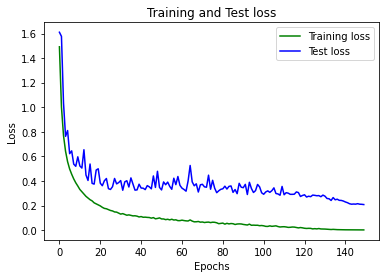

In [ ]:
# Plot Training and Validation loss
import matplotlib.pyplot as plt
epochs = range(0,len(train_loss_history))
plt.plot(epochs, train_loss_history, 'g', label='Training loss')
plt.plot(epochs, test_loss_history, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

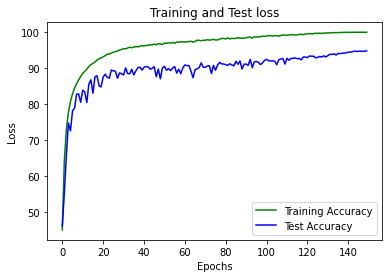

In [ ]:
# Plot Training and Validation loss
import matplotlib.pyplot as plt
epochs = range(0,len(train_loss_history))
plt.plot(epochs, train_accuracy_history, 'g', label='Training Accuracy')
plt.plot(epochs, test_accuracy_history, 'b', label='Test Accuracy')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()